In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [2]:
# Task 1: Data Exploration and Preprocessing
# Load the dataset
df = pd.read_csv('Alphabets_data.csv')

print("--- Data Summary ---")
print(f"Number of samples: {len(df)}")
print(f"Number of features: {df.shape[1] - 1}")
print(f"Number of classes: {df['letter'].nunique()}")
print(f"Classes: {sorted(df['letter'].unique())}")

--- Data Summary ---
Number of samples: 20000
Number of features: 16
Number of classes: 26
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [3]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum().sum())


Missing Values:
 0


In [4]:
# Feature and Target Split
X = df.drop('letter', axis=1)
y = df['letter']

In [5]:
# Label Encoding for Target
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [6]:
# Normalization (Crucial for Neural Networks)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [8]:
# 3. Task 2: Basic ANN Model Implementation
def create_basic_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        Dense(32, activation='relu'),
        Dense(26, activation='softmax') # 26 classes for A-Z
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

basic_model = create_basic_model()
print("\n--- Basic Model Training ---")
history = basic_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=0)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Basic Model Training ---


In [9]:
# Evaluate Basic Model
y_pred_basic = np.argmax(basic_model.predict(X_test), axis=1)
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_basic):.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Basic Model Accuracy: 0.9247


In [10]:
# Task 3: Hyperparameter Tuning (Manual Grid Search)
# To avoid dependency issues in Colab with scikeras, we use a structured loop approach
print("\n--- Hyperparameter Tuning ---")

results = []
learning_rates = [0.001, 0.01]
neurons = [64, 128]
activations = ['relu', 'tanh']

for lr in learning_rates:
    for n in neurons:
        for act in activations:
            model = Sequential([
                Dense(n, activation=act, input_shape=(X_train.shape[1],)),
                Dense(n//2, activation=act),
                Dense(26, activation='softmax')
            ])
            model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
            model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

            acc = model.evaluate(X_test, y_test, verbose=0)[1]
            results.append({'lr': lr, 'neurons': n, 'activation': act, 'accuracy': acc})
            print(f"Tested: LR={lr}, Neurons={n}, Act={act} -> Accuracy: {acc:.4f}")


--- Hyperparameter Tuning ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Tested: LR=0.001, Neurons=64, Act=relu -> Accuracy: 0.8763
Tested: LR=0.001, Neurons=64, Act=tanh -> Accuracy: 0.8627
Tested: LR=0.001, Neurons=128, Act=relu -> Accuracy: 0.9275
Tested: LR=0.001, Neurons=128, Act=tanh -> Accuracy: 0.9013
Tested: LR=0.01, Neurons=64, Act=relu -> Accuracy: 0.9262
Tested: LR=0.01, Neurons=64, Act=tanh -> Accuracy: 0.9115
Tested: LR=0.01, Neurons=128, Act=relu -> Accuracy: 0.9327
Tested: LR=0.01, Neurons=128, Act=tanh -> Accuracy: 0.9193


In [11]:
# Find Best Model
best_params = max(results, key=lambda x: x['accuracy'])
print("\nBest Hyperparameters Found:", best_params)


Best Hyperparameters Found: {'lr': 0.01, 'neurons': 128, 'activation': 'relu', 'accuracy': 0.9327499866485596}


In [12]:
# Task 4: Evaluation and Final Comparison
# Train final tuned model with best parameters
tuned_model = Sequential([
    Dense(best_params['neurons'], activation=best_params['activation'], input_shape=(X_train.shape[1],)),
    Dense(best_params['neurons']//2, activation=best_params['activation']),
    Dense(26, activation='softmax')
])
tuned_model.compile(optimizer=Adam(learning_rate=best_params['lr']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tuned_model.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

y_pred_tuned = np.argmax(tuned_model.predict(X_test), axis=1)

print("\n--- Final Tuned Model Evaluation ---")
print(classification_report(y_test, y_pred_tuned, target_names=le.classes_))

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Final Tuned Model Evaluation ---
              precision    recall  f1-score   support

           A       0.97      0.99      0.98       149
           B       0.92      0.92      0.92       153
           C       0.95      0.93      0.94       137
           D       0.96      0.87      0.91       156
           E       0.94      0.93      0.93       141
           F       0.90      0.94      0.92       140
           G       0.91      0.97      0.94       160
           H       0.88      0.85      0.87       144
           I       0.99      0.92      0.95       146
           J       0.93      0.92      0.93       149
           K       0.93      0.88      0.90       130
           L       0.98      0.93      0.95       155
           M       0.96      0.98      0.97       168
           N       0.97      0.89      0.93       151
           O       0.91      0.96      0.93       145
           P       0.95      0.94      0.95       173
  

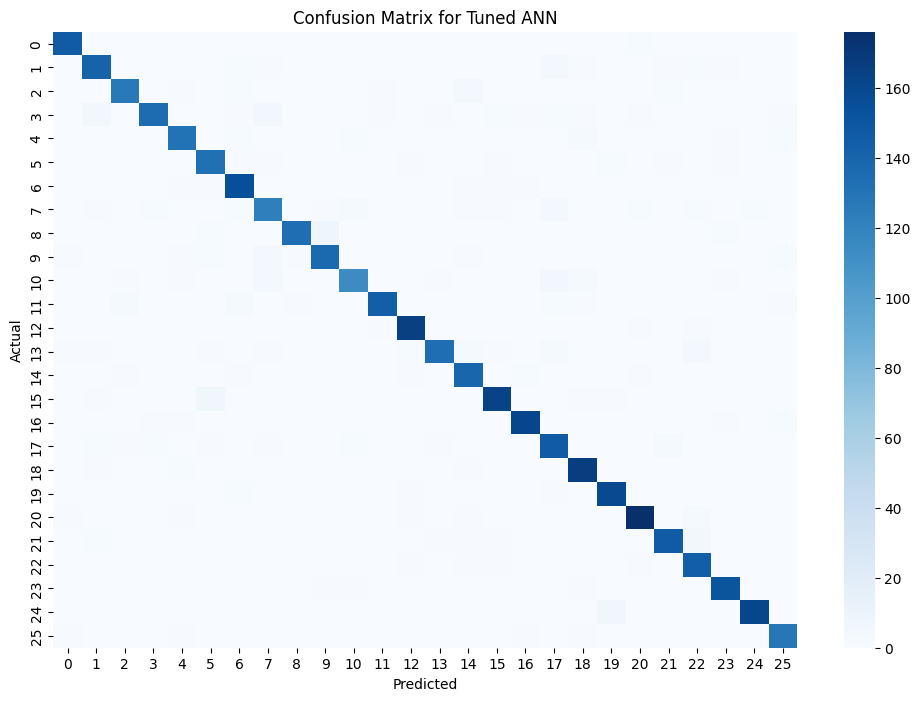

In [13]:
# Visualizing Performance
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix for Tuned ANN')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()